# **Projeto de Segmentação de Clientes - Comparativo de Algoritmos de Agrupamento**

O objetivo desse projeto é comparar diferentes algoritmos de agrupamento e criar segmentações de clientes de um e-commerce.

Fonte dos dados: https://www.kaggle.com/datasets/carrie1/ecommerce-data/code

In [101]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder

# ignorar warnings
warnings.filterwarnings('ignore')

In [2]:
# montar o drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# procurar e carregar o arquivo
FILE_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/AlgoritmosInteligenciaArtificialClusterizacao/datasets'
data = pd.read_csv(os.path.join(FILE_PATH, 'e_commerce_data.csv'), encoding="ISO-8859-1")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# entender os tipos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# como ocorrem dados nulos? - quantidade
data.isna().sum() / data.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [6]:
data.loc[data['Description'].isna(), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [7]:
# explorando os stock codes
data.loc[data['StockCode']=='22145', 'Description'].value_counts()

CHRISTMAS CRAFT HEART STOCKING     1
Name: Description, dtype: int64

In [8]:
# vamos identificar a lista de valores únicos do stockcode
stock_unique = data['StockCode'].unique()

In [9]:
def replace_missing_prod(stock, data):

  # identificar a description relacionada àquele code
  counts = data.loc[data['StockCode']==stock, 'Description'].value_counts()

  if counts.shape[0] > 0:
    prod_name = counts.index[0]

    # assumimos que tudo que for diferente da classe de produtos
    # majoritária, foi erro de anotação.

    # substituir todos as linhas com o código,
    # pelo nome da classe majoratária
    data.loc[data['StockCode'] == stock, 'Description'] = prod_name

In [10]:
# como ocorrem dados nulos? - quantidade
# data['StockCode'].apply(replace_missing_prod, data=data)

- paramos a execução da substituição por conta do tempo.

In [11]:
# neste caso, vamos eliminar as linhas que ainda estão nulas
data.isna().sum() / data.shape[0]

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [12]:
# CustomerID não costuma ser uma variável bem importante
data.drop(columns=['CustomerID'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 28.9+ MB


In [13]:
# eliminar dados nulos
data.dropna(inplace=True)
data.isna().sum() / data.shape[0]

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
Country        0.0
dtype: float64

In [14]:
# explorando principais descriptions
data['Description'].value_counts().tail(10)

BAROQUE BUTTERFLY EARRINGS RED         1
ORANGE/FUSCHIA STONES NECKLACE         1
MARIE ANTOIENETT TRINKET BOX GOLD      1
Display                                1
BLACKCHRISTMAS TREE 30CM               1
Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: Description, dtype: int64

In [15]:
# filtrar a base de dados para o top 50 de contagens de produtos
prods = data['Description'].value_counts().head(50).index

data_selec = data.loc[data['Description'].isin(prods), :]
data_selec.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,United Kingdom
21,536368,22960,JAM MAKING SET WITH JARS,6,12/1/2010 8:34,4.25,United Kingdom
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/2010 8:45,3.75,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/2010 8:45,3.75,France


In [16]:
# comparando tamanhos das bases
data_selec.shape[0] / data.shape[0]

0.11148939319647334

In [17]:
data_selec.shape

(60255, 7)

In [18]:
# eliminando colunas não utilizadas
data_selec.drop(columns=['InvoiceNo', 'StockCode'], inplace=True)
data_selec.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom
9,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,United Kingdom
21,JAM MAKING SET WITH JARS,6,12/1/2010 8:34,4.25,United Kingdom
27,ALARM CLOCK BAKELIKE RED,24,12/1/2010 8:45,3.75,France
28,ALARM CLOCK BAKELIKE GREEN,12,12/1/2010 8:45,3.75,France


In [19]:
# criar novas features com a coluna Invoice Date
data_selec['InvoiceDate'] = pd.to_datetime(data_selec['InvoiceDate'])
data_selec.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom
9,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,United Kingdom
21,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,United Kingdom
27,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,France
28,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,France


In [20]:
# dia da semana e o dia do mês
data_selec['DayofWeek'] = data_selec['InvoiceDate'].dt.day_name()
data_selec.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country,DayofWeek
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,Wednesday
9,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,United Kingdom,Wednesday
21,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,United Kingdom,Wednesday
27,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,France,Wednesday
28,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,France,Wednesday


In [21]:
# dia da semana e o dia do mês
data_selec['MonthDay'] = data_selec['InvoiceDate'].dt.day
data_selec['BuyHour'] = data_selec['InvoiceDate'].dt.hour
data_selec.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country,DayofWeek,MonthDay,BuyHour
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,Wednesday,1,8
9,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,United Kingdom,Wednesday,1,8
21,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,United Kingdom,Wednesday,1,8
27,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,France,Wednesday,1,8
28,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,France,Wednesday,1,8


In [22]:
# criando o atributo 'TotalPrice'
data_selec['TotalPrice'] = data_selec['Quantity'] * data_selec['UnitPrice']
data_selec.head()

,Description,Quantity,InvoiceDate,UnitPrice,Country,DayofWeek,MonthDay,BuyHour,TotalPrice
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,Wednesday,1,8,15.30
9,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,United Kingdom,Wednesday,1,8,54.08
21,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,United Kingdom,Wednesday,1,8,25.50
27,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,France,Wednesday,1,8,90.00
28,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,France,Wednesday,1,8,45.00


In [23]:
data_selec.drop(columns=['Quantity', 'UnitPrice'], inplace=True)

In [24]:
# qual país gasta mais no e-commerce? -> país com maior soma, média de total price
group = data_selec.groupby(['Country'])['TotalPrice'].agg(func=[np.sum, np.mean])
group.sort_values(by=['mean'], ascending=False)

,sum,mean
Country,,
Japan,7651.48,364.356190
Netherlands,51325.03,176.982862
Australia,22024.87,125.856400
Sweden,6660.40,93.808451
Canada,888.31,68.331538
Malta,762.15,63.512500
Brazil,367.50,61.250000
Lebanon,360.15,60.025000
Norway,5366.86,54.763878


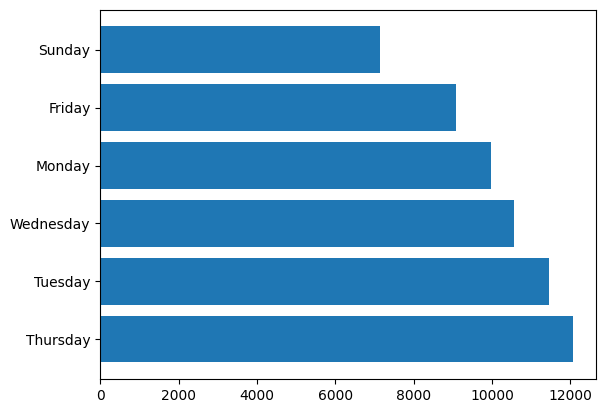

In [25]:
# qual dia da semana mais compras? -> qual dia da semana tem mais registros?
group = data_selec['DayofWeek'].value_counts()
plt.barh(y=group.index, width=group.values)
plt.show()

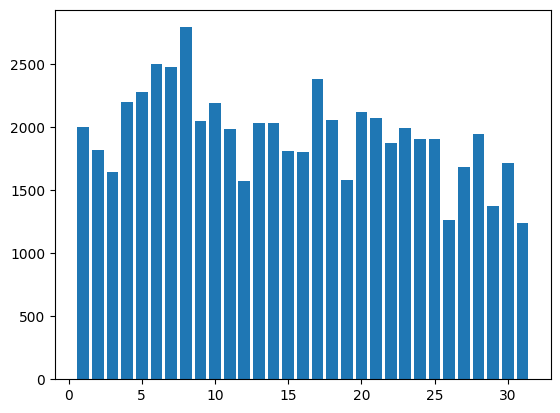

In [26]:
# qual dia da mês com mais compras? -> qual dia da mês tem mais registros?
group = data_selec['MonthDay'].value_counts()
plt.bar(x=group.index, height=group.values)
plt.show()

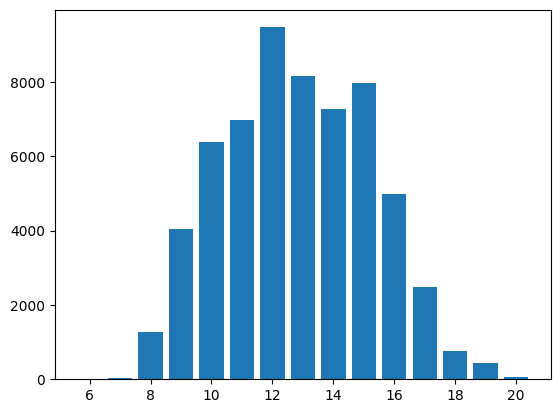

In [27]:
# qual hora com mais compras? -> qual hora do dia tem mais registros?
group = data_selec['BuyHour'].value_counts()
plt.bar(x=group.index, height=group.values)
plt.show()

In [28]:
# eliminando coluna de data
data_selec.drop(columns=['InvoiceDate'], inplace=True)

In [29]:
# agrupar dia do mês e hora de compra
data_selec['MonthDay'] = data_selec['MonthDay'].apply(lambda x: 1 if x > 15 else 0)
data_selec['BuyHour'] = data_selec['BuyHour'].apply(lambda x: 1 if x > 12 else 0)
data_selec.head()

,Description,Country,DayofWeek,MonthDay,BuyHour,TotalPrice
0,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,Wednesday,0,0,15.30
9,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom,Wednesday,0,0,54.08
21,JAM MAKING SET WITH JARS,United Kingdom,Wednesday,0,0,25.50
27,ALARM CLOCK BAKELIKE RED,France,Wednesday,0,0,90.00
28,ALARM CLOCK BAKELIKE GREEN,France,Wednesday,0,0,45.00


In [30]:
# criar um transformador de var. categóricas
cat_transform = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ['Description', 'Country', 'DayofWeek'])
])

In [31]:
# selecionando o número de k - Método do Cotovelo
n_clusters = range(1, 21)

wcss = []
for k in n_clusters:

  # cria um pipeline de modelagem
  kmeans_test = Pipeline([
      ('cat_transf', cat_transform),
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustar o modelo
  kmeans_test.fit(data_selec)

  # extrair o WCSS
  wcss.append(kmeans_test['kmeans'].inertia_)

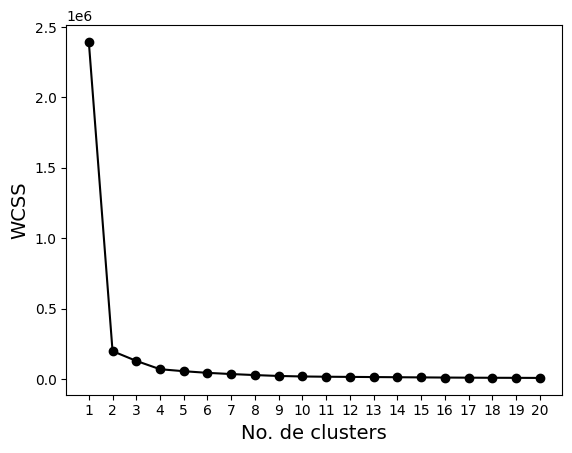

In [32]:
# construindo o método do cotovelo
plt.plot(n_clusters, wcss, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('WCSS', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.show()

 - Implementar a seleção de clusters pelo método da Silhueta
 - Implementar a seleção de clusters pelo método do Gap Analysis

In [36]:
# método da silhueta
s_score = []
n_clusters = range(2, 6)

for k in n_clusters:

  print(f'Analisando o caso k={k}')

  # cria um pipeline de modelagem
  kmeans_test = Pipeline([
      ('cat_transf', cat_transform),
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustar o modelo
  kmeans_test.fit(data_selec)

  # criando um x_transformado -> para o score de silhueta
  x_transf = kmeans_test['cat_transf'].transform(data_selec)
  x_transf = kmeans_test['scaler'].transform(x_transf)

  # atribuição dos pontos nos clusters
  cluster_labels = kmeans_test.predict(data_selec)

  # armazena o score de silhueta
  s_score.append(silhouette_score(X=x_transf, labels=cluster_labels))

Analisando o caso k=2
Analisando o caso k=3
Analisando o caso k=4
Analisando o caso k=5


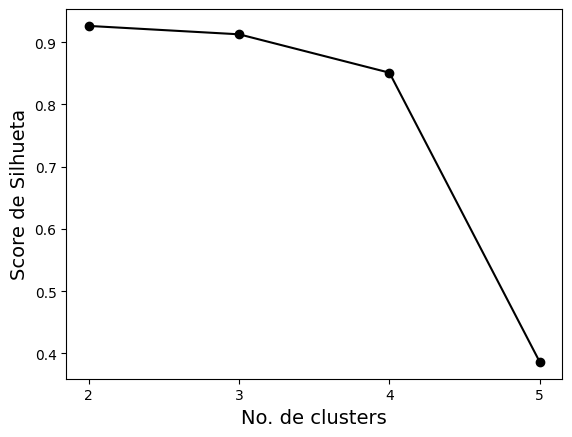

In [37]:
# construir um gráfico do score de silhueta
plt.plot(n_clusters, s_score, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('Score de Silhueta', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.show()

In [39]:
# método do gap analysis
wcss_real = []
wcss_ref = []
n_clusters = range(1, 11)

# calculando o gap analysis para cada k
for k in n_clusters:

  print(f'Analisando o caso k={k}')

  # cria um pipeline de modelagem
  kmeans_test = Pipeline([
      ('cat_transf', cat_transform),
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustar o modelo
  kmeans_test.fit(data_selec)

  # extrai o WCSS real
  wcss_real.append(np.log(kmeans_test['kmeans'].inertia_))

  # gerar os dados de referência (clusters aleatórios)
  ref_x = np.random.rand(data_selec.shape[0], data_selec.shape[1])

  # cria um pipeline de modelagem
  kmeans_fake = Pipeline([
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustando o modelo
  kmeans_fake.fit(ref_x)

  # extrai o WCSS simulado
  wcss_ref.append(np.log(kmeans_fake['kmeans'].inertia_))

Analisando o caso k=1
Analisando o caso k=2
Analisando o caso k=3
Analisando o caso k=4
Analisando o caso k=5
Analisando o caso k=6
Analisando o caso k=7
Analisando o caso k=8
Analisando o caso k=9
Analisando o caso k=10


In [40]:
# calculando o Gap Statistics
gap = np.subtract(wcss_ref, wcss_real)

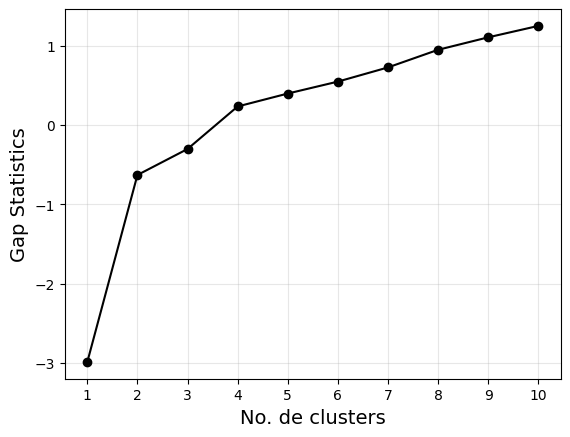

In [41]:
# construir o gráfico do gap statistics
plt.plot(n_clusters, gap, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('Gap Statistics', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.grid(alpha=0.3)
plt.show()

In [42]:
# DEFINIÇÃO FINAL
k = 2

# cria um pipeline de modelagem
kmeans_final = Pipeline([
    ('cat_transf', cat_transform),
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_clusters=k, init='k-means++'))
])

# ajustar o modelo
kmeans_final.fit(data_selec)

# atribuições dos pontos
data = data_selec.copy()
data['cluster'] = kmeans_final.predict(data_selec)

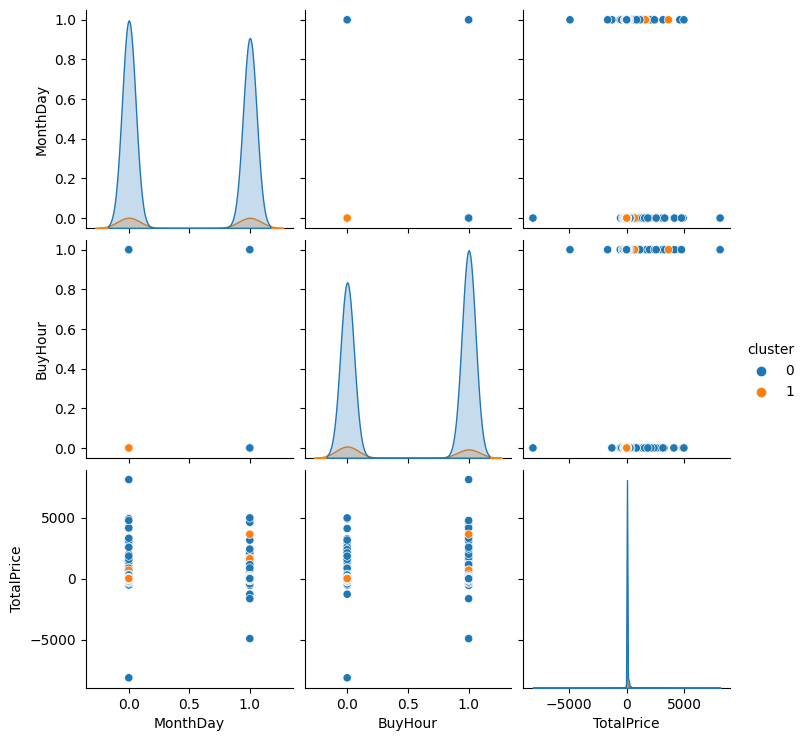

In [45]:
# plotar um histograma
sns.pairplot(data, hue='cluster')
plt.show()

- todos fomos enganados pelos resultados da clusterização. Ainda existem dados inconsistentes (preços negativos ou zerados) e um cliente isolado com TotalPrice > 5000

In [59]:
# limpando clientes inconsistentes e extremos
data_selec = data_selec.loc[
    ((data_selec['TotalPrice'] > 0) & (data_selec['TotalPrice'] <= 100)), :
]

In [69]:
data_selec.drop(columns=['MonthDay', 'BuyHour'], inplace=True)

<Axes: >

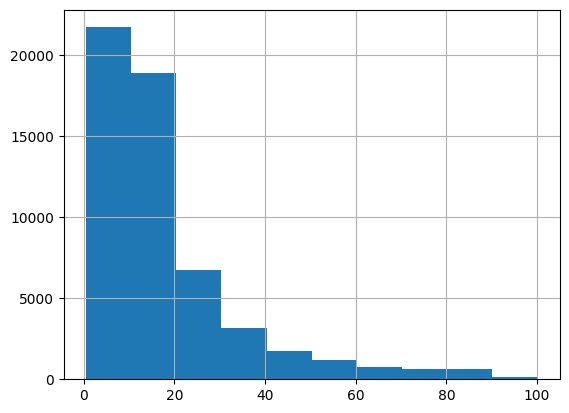

In [60]:
data_selec['TotalPrice'].hist()

In [70]:
# selecionando o número de k - Método do Cotovelo
n_clusters = range(1, 21)

wcss = []
for k in n_clusters:

  print(f'Analisando o caso k={k}')

  # cria um pipeline de modelagem
  kmeans_test = Pipeline([
      ('cat_transf', cat_transform),
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustar o modelo
  kmeans_test.fit(data_selec)

  # extrair o WCSS
  wcss.append(kmeans_test['kmeans'].inertia_)

Analisando o caso k=1
Analisando o caso k=2
Analisando o caso k=3
Analisando o caso k=4
Analisando o caso k=5
Analisando o caso k=6
Analisando o caso k=7
Analisando o caso k=8
Analisando o caso k=9
Analisando o caso k=10
Analisando o caso k=11
Analisando o caso k=12
Analisando o caso k=13
Analisando o caso k=14
Analisando o caso k=15
Analisando o caso k=16
Analisando o caso k=17
Analisando o caso k=18
Analisando o caso k=19
Analisando o caso k=20


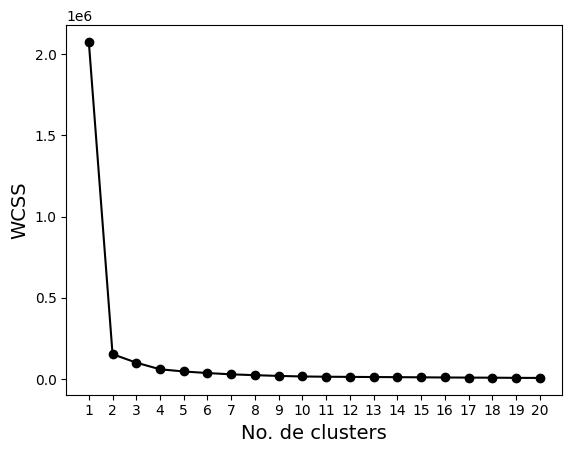

In [71]:
# construindo o método do cotovelo
plt.plot(n_clusters, wcss, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('WCSS', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.show()

In [72]:
# método da silhueta
s_score = []
n_clusters = range(2, 6)

for k in n_clusters:

  print(f'Analisando o caso k={k}')

  # cria um pipeline de modelagem
  kmeans_test = Pipeline([
      ('cat_transf', cat_transform),
      ('scaler', RobustScaler()),
      ('kmeans', KMeans(n_clusters=k, init='k-means++'))
  ])

  # ajustar o modelo
  kmeans_test.fit(data_selec)

  # criando um x_transformado -> para o score de silhueta
  x_transf = kmeans_test['cat_transf'].transform(data_selec)
  x_transf = kmeans_test['scaler'].transform(x_transf)

  # atribuição dos pontos nos clusters
  cluster_labels = kmeans_test.predict(data_selec)

  # armazena o score de silhueta
  s_score.append(silhouette_score(X=x_transf, labels=cluster_labels))

Analisando o caso k=2
Analisando o caso k=3
Analisando o caso k=4
Analisando o caso k=5


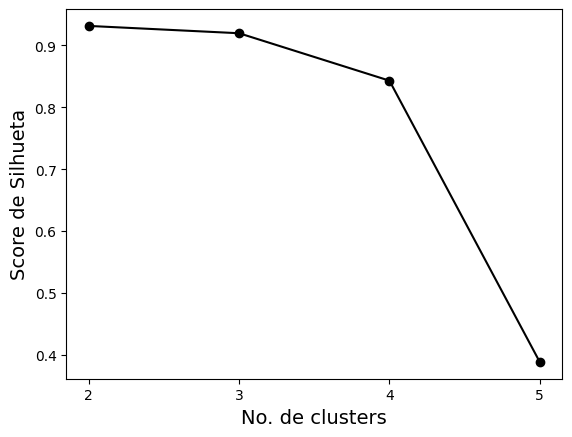

In [73]:
# construir um gráfico do score de silhueta
plt.plot(n_clusters, s_score, 'ko-')
plt.xlabel('No. de clusters', size=14)
plt.ylabel('Score de Silhueta', size=14)
plt.xticks(ticks=n_clusters, labels=n_clusters)
plt.show()

In [74]:
# DEFINIÇÃO FINAL
k = 2

# cria um pipeline de modelagem
kmeans_final = Pipeline([
    ('cat_transf', cat_transform),
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_clusters=k, init='k-means++'))
])

# ajustar o modelo
kmeans_final.fit(data_selec)

# atribuições dos pontos
data = data_selec.copy()
data['cluster'] = kmeans_final.predict(data_selec)

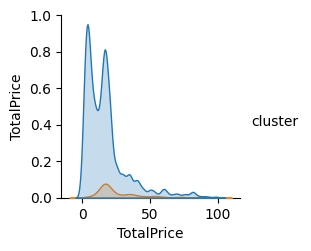

In [75]:
# plotar um histograma
sns.pairplot(data, hue='cluster')
plt.show()

In [76]:
# descrição estatística
data.groupby(['cluster']).describe().T

cluster                      0            1
TotalPrice count  51546.000000  4103.000000
           mean      17.084739    27.426549
           std       16.383315    18.431802
           min        0.550000     0.950000
           25%        4.960000    16.500000
           50%       14.850000    19.800000
           75%       20.800000    36.000000
           max      100.000000   100.000000

In [77]:
data.head()

,Description,Country,DayofWeek,TotalPrice,cluster
0,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,Wednesday,15.30,0
9,ASSORTED COLOUR BIRD ORNAMENT,United Kingdom,Wednesday,54.08,0
21,JAM MAKING SET WITH JARS,United Kingdom,Wednesday,25.50,0
27,ALARM CLOCK BAKELIKE RED,France,Wednesday,90.00,1
28,ALARM CLOCK BAKELIKE GREEN,France,Wednesday,45.00,1


In [91]:
# descrição de contagem de itens em cada cluster
display(data.groupby(['cluster', 'Description'])['Description'].count().loc[0, :].sort_values(ascending=False).head(10))
print('\n')
display(data.groupby(['cluster', 'Description'])['Description'].count().loc[1, :].sort_values(ascending=False).head(10))

Description
WHITE HANGING HEART T-LIGHT HOLDER    2149
JUMBO BAG RED RETROSPOT               1772
PARTY BUNTING                         1444
REGENCY CAKESTAND 3 TIER              1401
LUNCH BAG RED RETROSPOT               1389
ASSORTED COLOUR BIRD ORNAMENT         1359
LUNCH BAG  BLACK SKULL.               1254
SET OF 3 CAKE TINS PANTRY DESIGN      1248
PACK OF 72 RETROSPOT CAKE CASES       1207
NATURAL SLATE HEART CHALKBOARD        1205
Name: Description, dtype: int64

Description
POSTAGE                                748
REGENCY CAKESTAND 3 TIER               176
SPACEBOY LUNCH BOX                     137
PACK OF 72 RETROSPOT CAKE CASES        136
LUNCH BAG RED RETROSPOT                122
LUNCH BAG WOODLAND                     121
JAM MAKING SET PRINTED                 120
SET/20 RED RETROSPOT PAPER NAPKINS     116
JUMBO BAG RED RETROSPOT                115
RABBIT NIGHT LIGHT                     110
Name: Description, dtype: int64

In [92]:
# descrição de contagem de itens em cada cluster
display(data.groupby(['cluster', 'Country'])['Country'].count().loc[0, :].sort_values(ascending=False).head(10))
print('\n')
display(data.groupby(['cluster', 'Country'])['Country'].count().loc[1, :].sort_values(ascending=False).head(10))

Country
United Kingdom    50538
Spain               286
Portugal            202
Switzerland         165
Netherlands         112
Norway               90
Sweden               46
Poland               32
Unspecified          27
Singapore            17
Name: Country, dtype: int64

Country
France             1214
Germany            1135
EIRE                802
Belgium             336
Australia            96
Italy                95
Channel Islands      81
Finland              69
Cyprus               55
Austria              41
Name: Country, dtype: int64

In [93]:
# descrição de contagem de itens em cada cluster
display(data.groupby(['cluster', 'DayofWeek'])['DayofWeek'].count().loc[0, :].sort_values(ascending=False))
print('\n')
display(data.groupby(['cluster', 'DayofWeek'])['DayofWeek'].count().loc[1, :].sort_values(ascending=False))

DayofWeek
Thursday     10189
Tuesday       9820
Wednesday     8903
Monday        8476
Friday        7567
Sunday        6591
Name: DayofWeek, dtype: int64

DayofWeek
Thursday     883
Friday       766
Monday       763
Wednesday    725
Tuesday      681
Sunday       285
Name: DayofWeek, dtype: int64

In [97]:
data.groupby(['cluster', 'DayofWeek', 'Country'])['DayofWeek'].count().loc[0, :].sort_values(ascending=False)

DayofWeek  Country             
Thursday   United Kingdom          9938
Tuesday    United Kingdom          9647
Wednesday  United Kingdom          8711
Monday     United Kingdom          8332
Friday     United Kingdom          7399
Sunday     United Kingdom          6511
Thursday   Spain                     82
           Portugal                  57
Wednesday  Spain                     45
           Switzerland               44
Friday     Spain                     43
Monday     Portugal                  41
           Spain                     41
Tuesday    Spain                     39
           Netherlands               38
Thursday   Switzerland               37
Sunday     Spain                     36
Wednesday  Portugal                  35
Friday     Switzerland               32
Tuesday    Portugal                  28
Friday     Norway                    27
           Portugal                  26
Wednesday  Norway                    25
Tuesday    Switzerland               25
Wednesda

In [99]:
data.groupby(['cluster', 'DayofWeek', 'Country'])['DayofWeek'].count().loc[1, :].sort_values(ascending=False).head(50)

DayofWeek  Country        
Thursday   Germany            278
Wednesday  France             264
Thursday   France             236
Friday     France             223
           Germany            214
Monday     France             211
           Germany            200
           EIRE               193
Tuesday    France             183
Wednesday  Germany            182
Tuesday    Germany            156
Friday     EIRE               148
Tuesday    EIRE               145
Wednesday  EIRE               138
Thursday   EIRE               137
Sunday     Germany            105
           France              97
Thursday   Belgium             84
Friday     Belgium             73
Tuesday    Belgium             66
Wednesday  Belgium             55
Sunday     EIRE                41
Monday     Belgium             41
Tuesday    Italy               30
Thursday   Finland             23
           Australia           23
Friday     Italy               22
Wednesday  Channel Islands     22
Tuesday    Australia 

In [100]:
# teste do Chi2

# tabela de contingências
cont_table = pd.crosstab(data['cluster'], data['DayofWeek'])
cont_table

DayofWeek,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday
cluster,,,,,,
0,7567,8476,6591,10189,9820,8903
1,766,763,285,883,681,725


- *Hipótese Nula - $H_0$* - não há associação entre as variáveis categóricas, elas são independentes e as diferenças observadas são devido à variabilidade aleatória. **Assim, seriam 8500 para cada dia no cluster 0 e 684, no cluster 1.**

- *Hipótese Alternativa - $H_1$* - existe evidência de uma associação entre as variáveis e as diferenças observadas ocorrem devido a essa possível associação.

In [102]:
# realizando o teste do chi2
stats, p_valor, gl, esperado = sts.chi2_contingency(cont_table)
print('Estatística: ', stats)
print('p_valor: ', p_valor)
print('Esperado: ', esperado)

Estatística:  174.26339839288332
p_valor:  8.979801673564779e-36
Esperado:  [[ 7718.6080253   8557.80865784  6369.03261514 10255.6615932
   9726.7614153   8918.12769322]
 [  614.3919747    681.19134216   506.96738486   816.3384068
    774.2385847    709.87230678]]
